# Convolutional Neural Network to detect Pneumonia

## 1. Importing Essential Libraries & Environment Setting

In [1]:
# Import required libraries
import kagglehub
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from PIL import Image
import itertools

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Activation, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

print('Modules Loaded')

Modules Loaded


## 2. Dataset Import and Path Setup

In [2]:
# Download the Chest X-ray dataset from Kaggle using kagglehub
paultimothymooney_chest_xray_pneumonia_path = kagglehub.dataset_download('paultimothymooney/chest-xray-pneumonia')

print('Data source import complete.')


Data source import complete.


## 3. Exploring the Dataset

In [3]:
# Exploring the structure of the dataset to ensure the directory and files are loaded correctly

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

## 4. Loading Data into DataFrames

### Loading Training Data:

In [4]:
# Loading and structuring the train data
train_data_path = os.path.join(paultimothymooney_chest_xray_pneumonia_path, 'chest_xray', 'train')

filepaths = []
labels = []

folds = os.listdir(train_data_path)
for file in folds:
    foldpath = os.path.join(train_data_path, file)
    filelist = os.listdir(foldpath)

    for f in filelist:
        fpath = os.path.join(foldpath, f)
        filepaths.append(fpath)
        labels.append(file)

FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

df = pd.concat([FSeries, LSeries], axis=1)

In [5]:
df

filepaths      label
0     /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
1     /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
2     /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
3     /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
4     /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
...                                                 ...        ...
5211  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
5212  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
5213  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
5214  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
5215  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL

[5216 rows x 2 columns]

In [6]:
df['label'].value_counts()

label
PNEUMONIA    3875
NORMAL       1341
Name: count, dtype: int64

### Loading Validation Data:

In [7]:
# Loading and structuring the validation data
valid_data_dir = os.path.join(paultimothymooney_chest_xray_pneumonia_path, 'chest_xray', 'val')
filepaths = []
labels = []

folds = os.listdir(valid_data_dir)
for fold in folds:
    foldpath = os.path.join(valid_data_dir, fold)
    filelist = os.listdir(foldpath)

    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

valid = pd.concat([FSeries, LSeries], axis=1)

In [8]:
valid

filepaths      label
0   /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
1   /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
2   /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
3   /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
4   /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
5   /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
6   /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
7   /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
8   /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
9   /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
10  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
11  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
12  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
13  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
14  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
15  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL

In [9]:
valid['label'].value_counts()

label
PNEUMONIA    8
NORMAL       8
Name: count, dtype: int64

### Loading Test Data:

In [10]:
# Loading and structuring the test data
test_data_dir = os.path.join(paultimothymooney_chest_xray_pneumonia_path, 'chest_xray', 'test')
filepaths = []
labels = []

folds = os.listdir(test_data_dir)

for f in folds:
    foldpath = os.path.join(test_data_dir,f)
    filelist = os.listdir(foldpath)

    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(f)

FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

test = pd.concat([FSeries, LSeries], axis=1)

In [11]:

test

filepaths      label
0    /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
1    /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
2    /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
3    /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
4    /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
..                                                 ...        ...
619  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
620  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
621  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
622  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
623  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL

[624 rows x 2 columns]

In [12]:
test['label'].value_counts()

label
PNEUMONIA    390
NORMAL       234
Name: count, dtype: int64

## 5. Data Splitting

In [13]:
# Splitting the dataset further
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=42)

## 6. Image Data Generators for Augmentiation & Preprocessing

In [14]:
# Defining Image Size and Batch Size
batch_size = 16
img_size = (224, 224)

# Create Image Data Generators for Train, Validation, and Test
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
val_gen= ImageDataGenerator()


# Creating batches
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = val_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 4172 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.


### Visualize Sample Images:

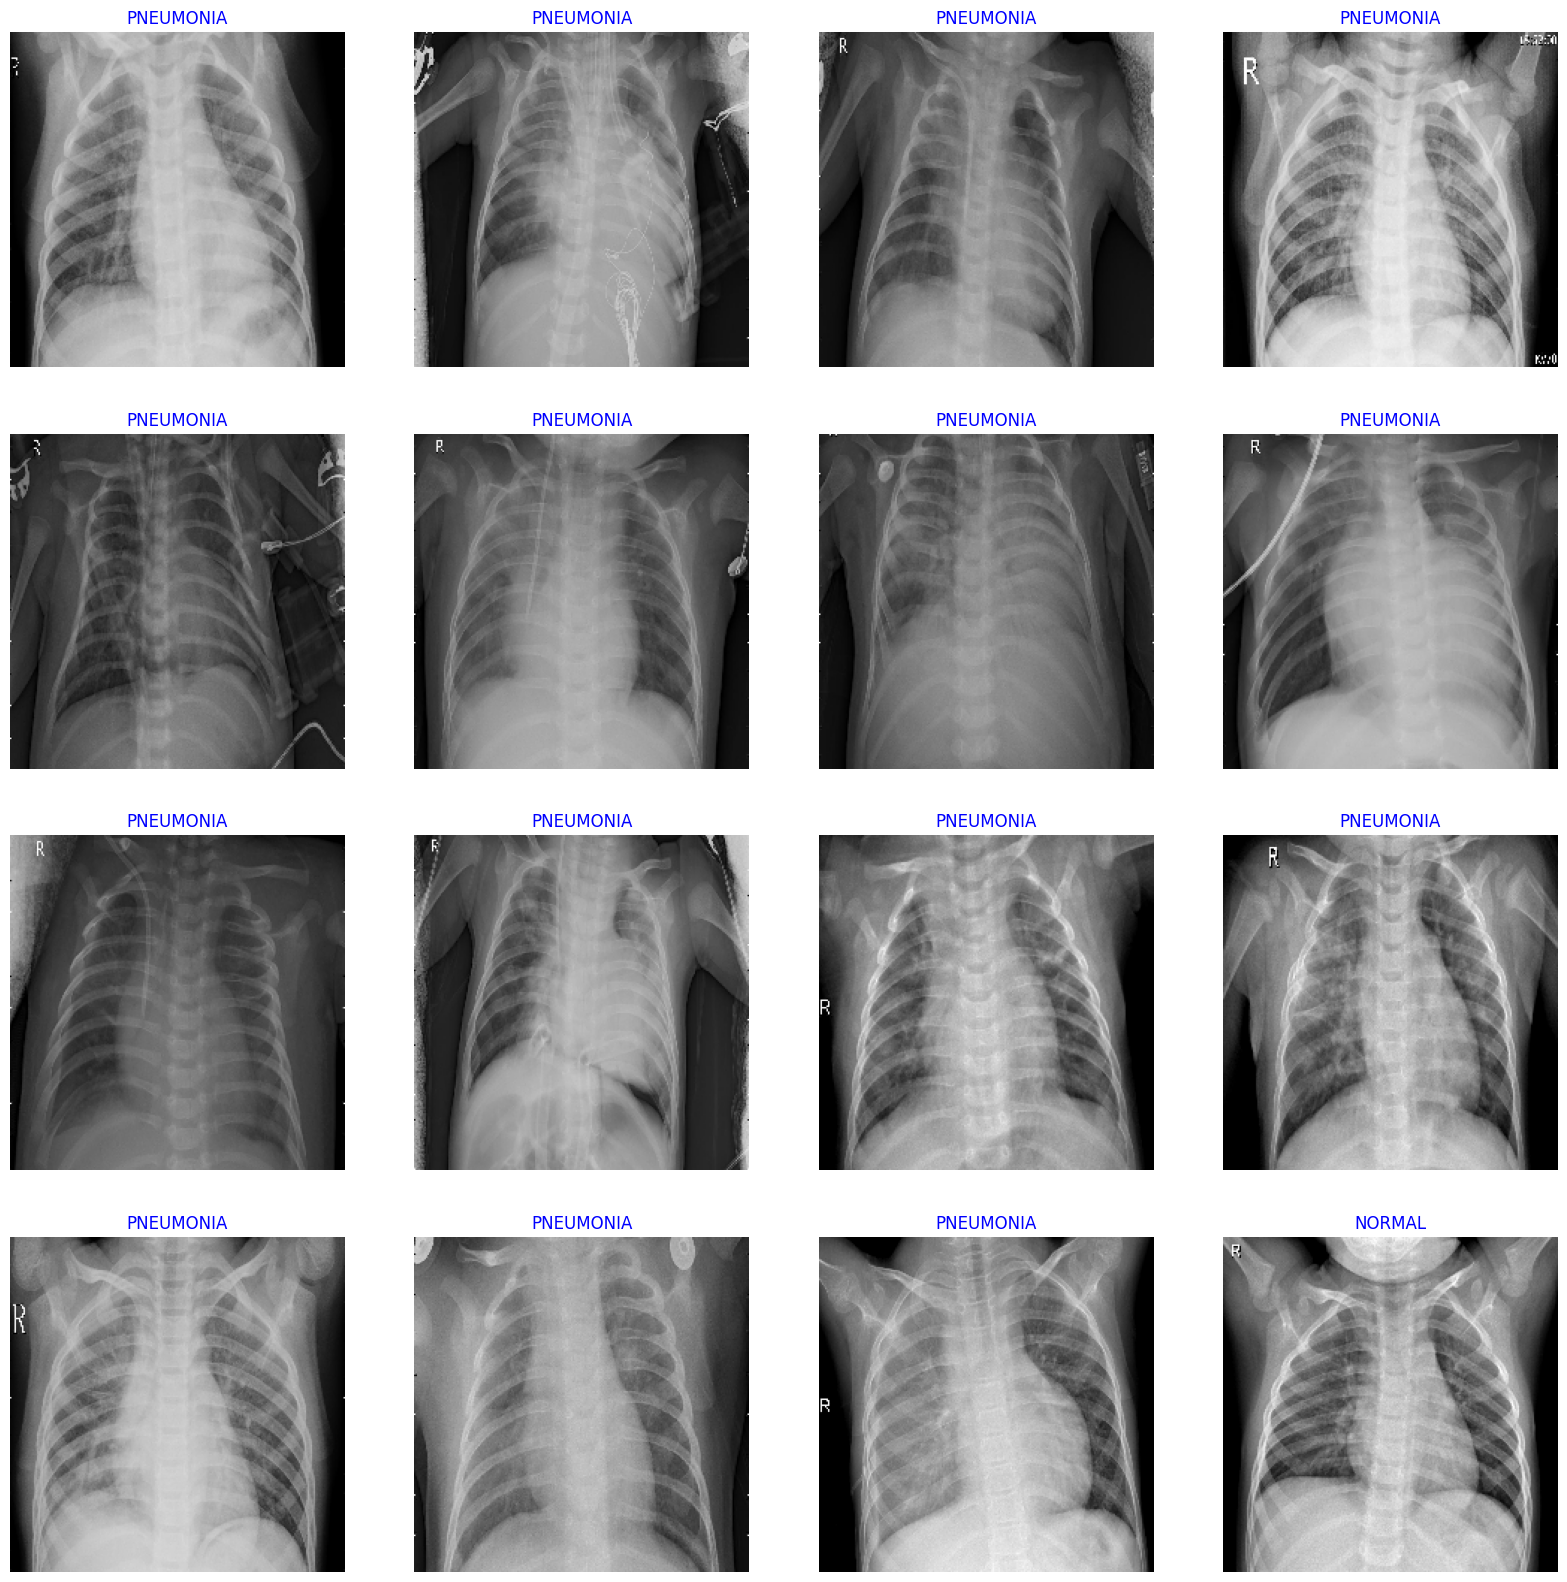

In [15]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show()

## 7. Building the Custom CNN Model

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_cnn_model(input_shape=(224, 224, 3)):
    model = models.Sequential(name="Custom_CNN")
    
    # ✅ Explicit Input Layer (Functional Style to ensure visibility)
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # ✅ Second Conv Block
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # ✅ Third Conv Block
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4)(x)

    # ✅ Fourth Conv Block
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4)(x)

    # ✅ Fifth Conv Block (Renamed for Grad-CAM compatibility)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name="block5_pool")(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4)(x)

    # ✅ Flatten and Dense Layers for Classification
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(2, activation='softmax')(x)

    # ✅ Return the functional model
    return tf.keras.Model(inputs=inputs, outputs=outputs, name="Custom_CNN")

# ✅ Initialize and Build the Model for Compatibility
model = create_cnn_model()
model.summary()


Model: "Custom_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (Conv2D)                 │ (None, 14, 14, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 14, 14, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,262,434 (8.63 MB)

 Trainable params: 2,262,434 (8.63 MB)

 Non-trainable params: 0 (0.00 B)

## 8. Compiling the Model

In [17]:
# from tensorflow.keras.callbacks import EarlyStopping

# # ✅ Define the EarlyStopping callback
# early_stopping = EarlyStopping(
#     monitor='val_loss',       # Monitor the validation loss for stopping
#     patience=5,               # Stop after 5 epochs with no improvement
#     restore_best_weights=True # Restore the best model state
# )

In [18]:
# Compile the model with Adamax optimizer and categorical cross-entropy loss
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

## 9. Training the Model

In [19]:
epochs = 25

# Train the model
history = model.fit(
    train_gen, 
    epochs= epochs, 
    verbose= 1, 
    validation_data= valid_gen, 
    #callbacks=[early_stopping], 
    shuffle= True)

Epoch 1/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 84s 274ms/step - accuracy: 0.6985 - loss: 2.4948 - val_accuracy: 0.7414 - val_loss: 0.6114
Epoch 2/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 39s 145ms/step - accuracy: 0.7487 - loss: 0.5565 - val_accuracy: 0.9004 - val_loss: 0.3699
Epoch 3/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 38s 142ms/step - accuracy: 0.8750 - loss: 0.2943 - val_accuracy: 0.9521 - val_loss: 0.1736
Epoch 4/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 38s 143ms/step - accuracy: 0.9174 - loss: 0.2019 - val_accuracy: 0.9502 - val_loss: 0.1450
Epoch 5/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 38s 144ms/step - accuracy: 0.9460 - loss: 0.1517 - val_accuracy: 0.9636 - val_loss: 0.1245
Epoch 6/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 38s 141ms/step - accuracy: 0.9452 - loss: 0.1465 - val_accuracy: 0.9579 - val_loss: 0.1393
Epoch 7/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 39s 147ms/step - accuracy: 0.9438 - loss: 0.1451 - val_accuracy: 0.9655 - val_loss: 0.1111
Epoch 8/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 39s 145ms/step - accuracy: 0.9561 - loss: 0

## 10. Results & Evaluation

### Training and Validation Performance:

<Axes: >

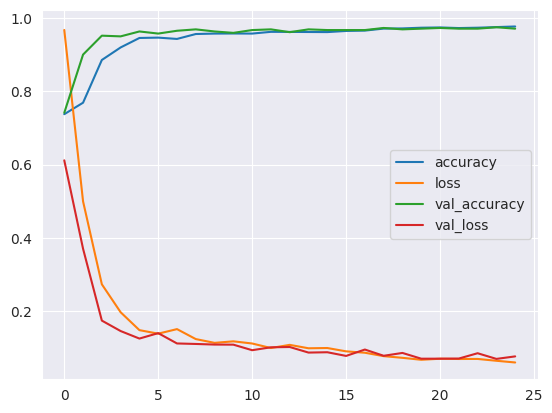

In [20]:
pd.DataFrame(history.history).plot()

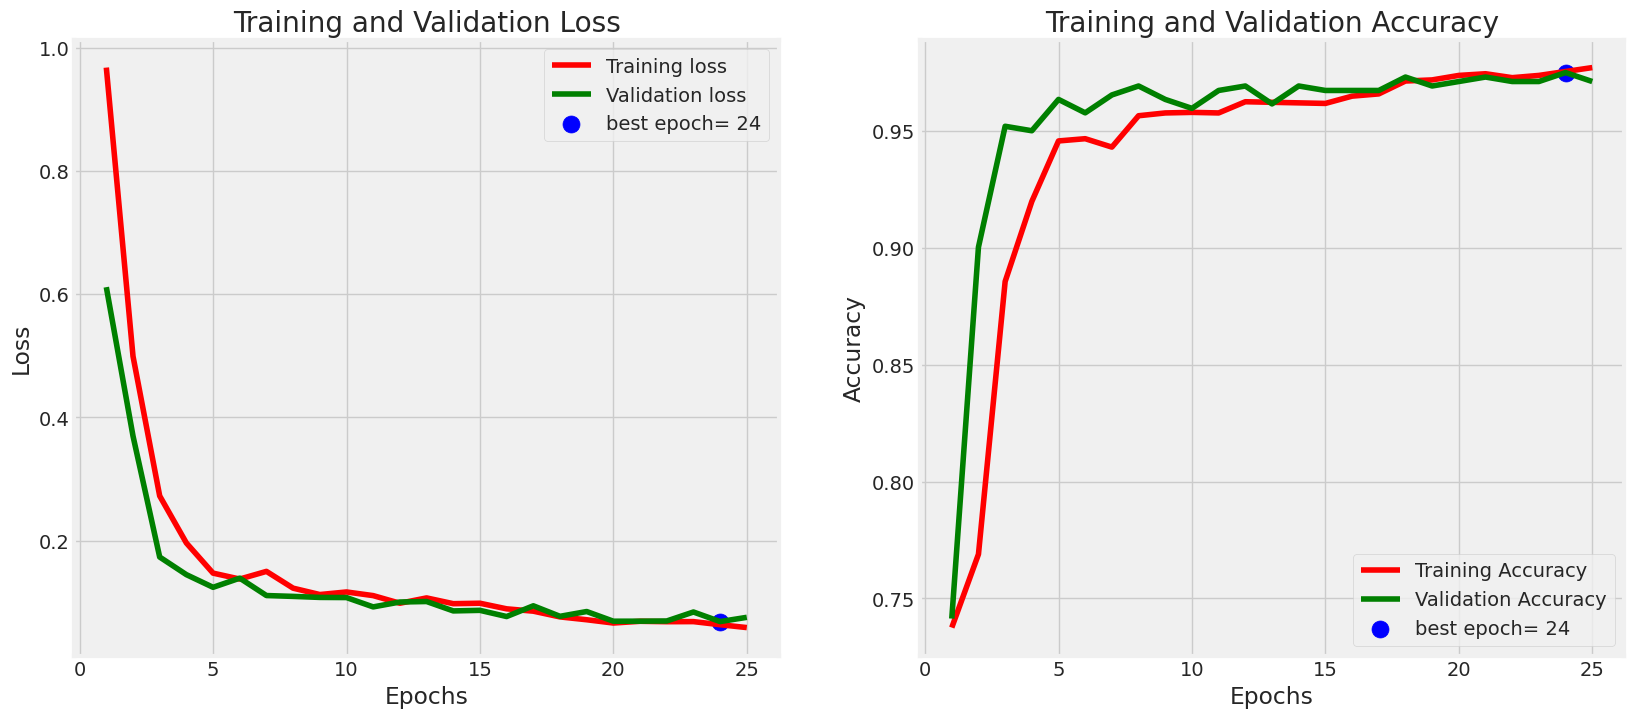

In [21]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [22]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

261/261 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - accuracy: 0.9810 - loss: 0.0479
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9676 - loss: 0.0997
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - accuracy: 0.9921 - loss: 0.0408
Train Loss:  0.0452161468565464
Train Accuracy:  0.9825024008750916
--------------------
Validation Loss:  0.07575482875108719
Validation Accuracy:  0.9712643623352051
--------------------
Test Loss:  0.06337135285139084
Test Accuracy:  0.9808428883552551


### Confusion Matrix:

In [23]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)
cm


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step


array([[153,   3],
       [  7, 359]])

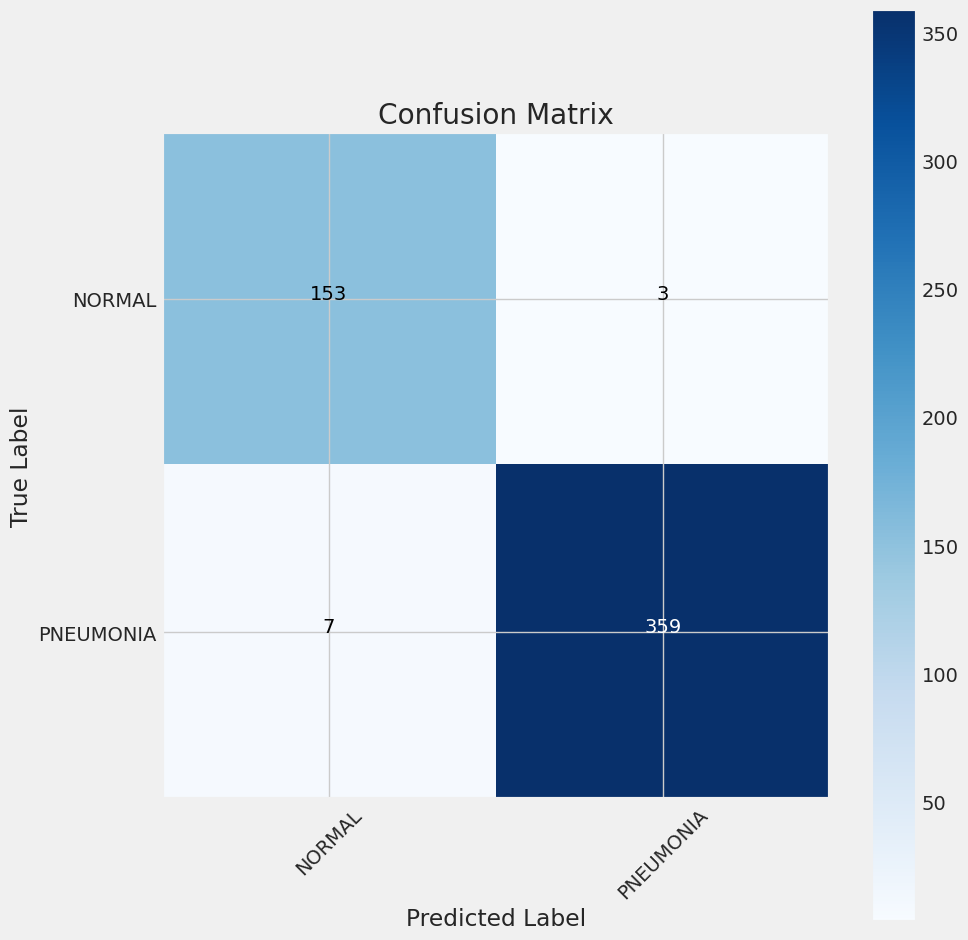

In [24]:

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Classification Report:

In [25]:
print(classification_report(test_gen.classes,y_pred,target_names=classes))

              precision    recall  f1-score   support

      NORMAL       0.96      0.98      0.97       156
   PNEUMONIA       0.99      0.98      0.99       366

    accuracy                           0.98       522
   macro avg       0.97      0.98      0.98       522
weighted avg       0.98      0.98      0.98       522



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


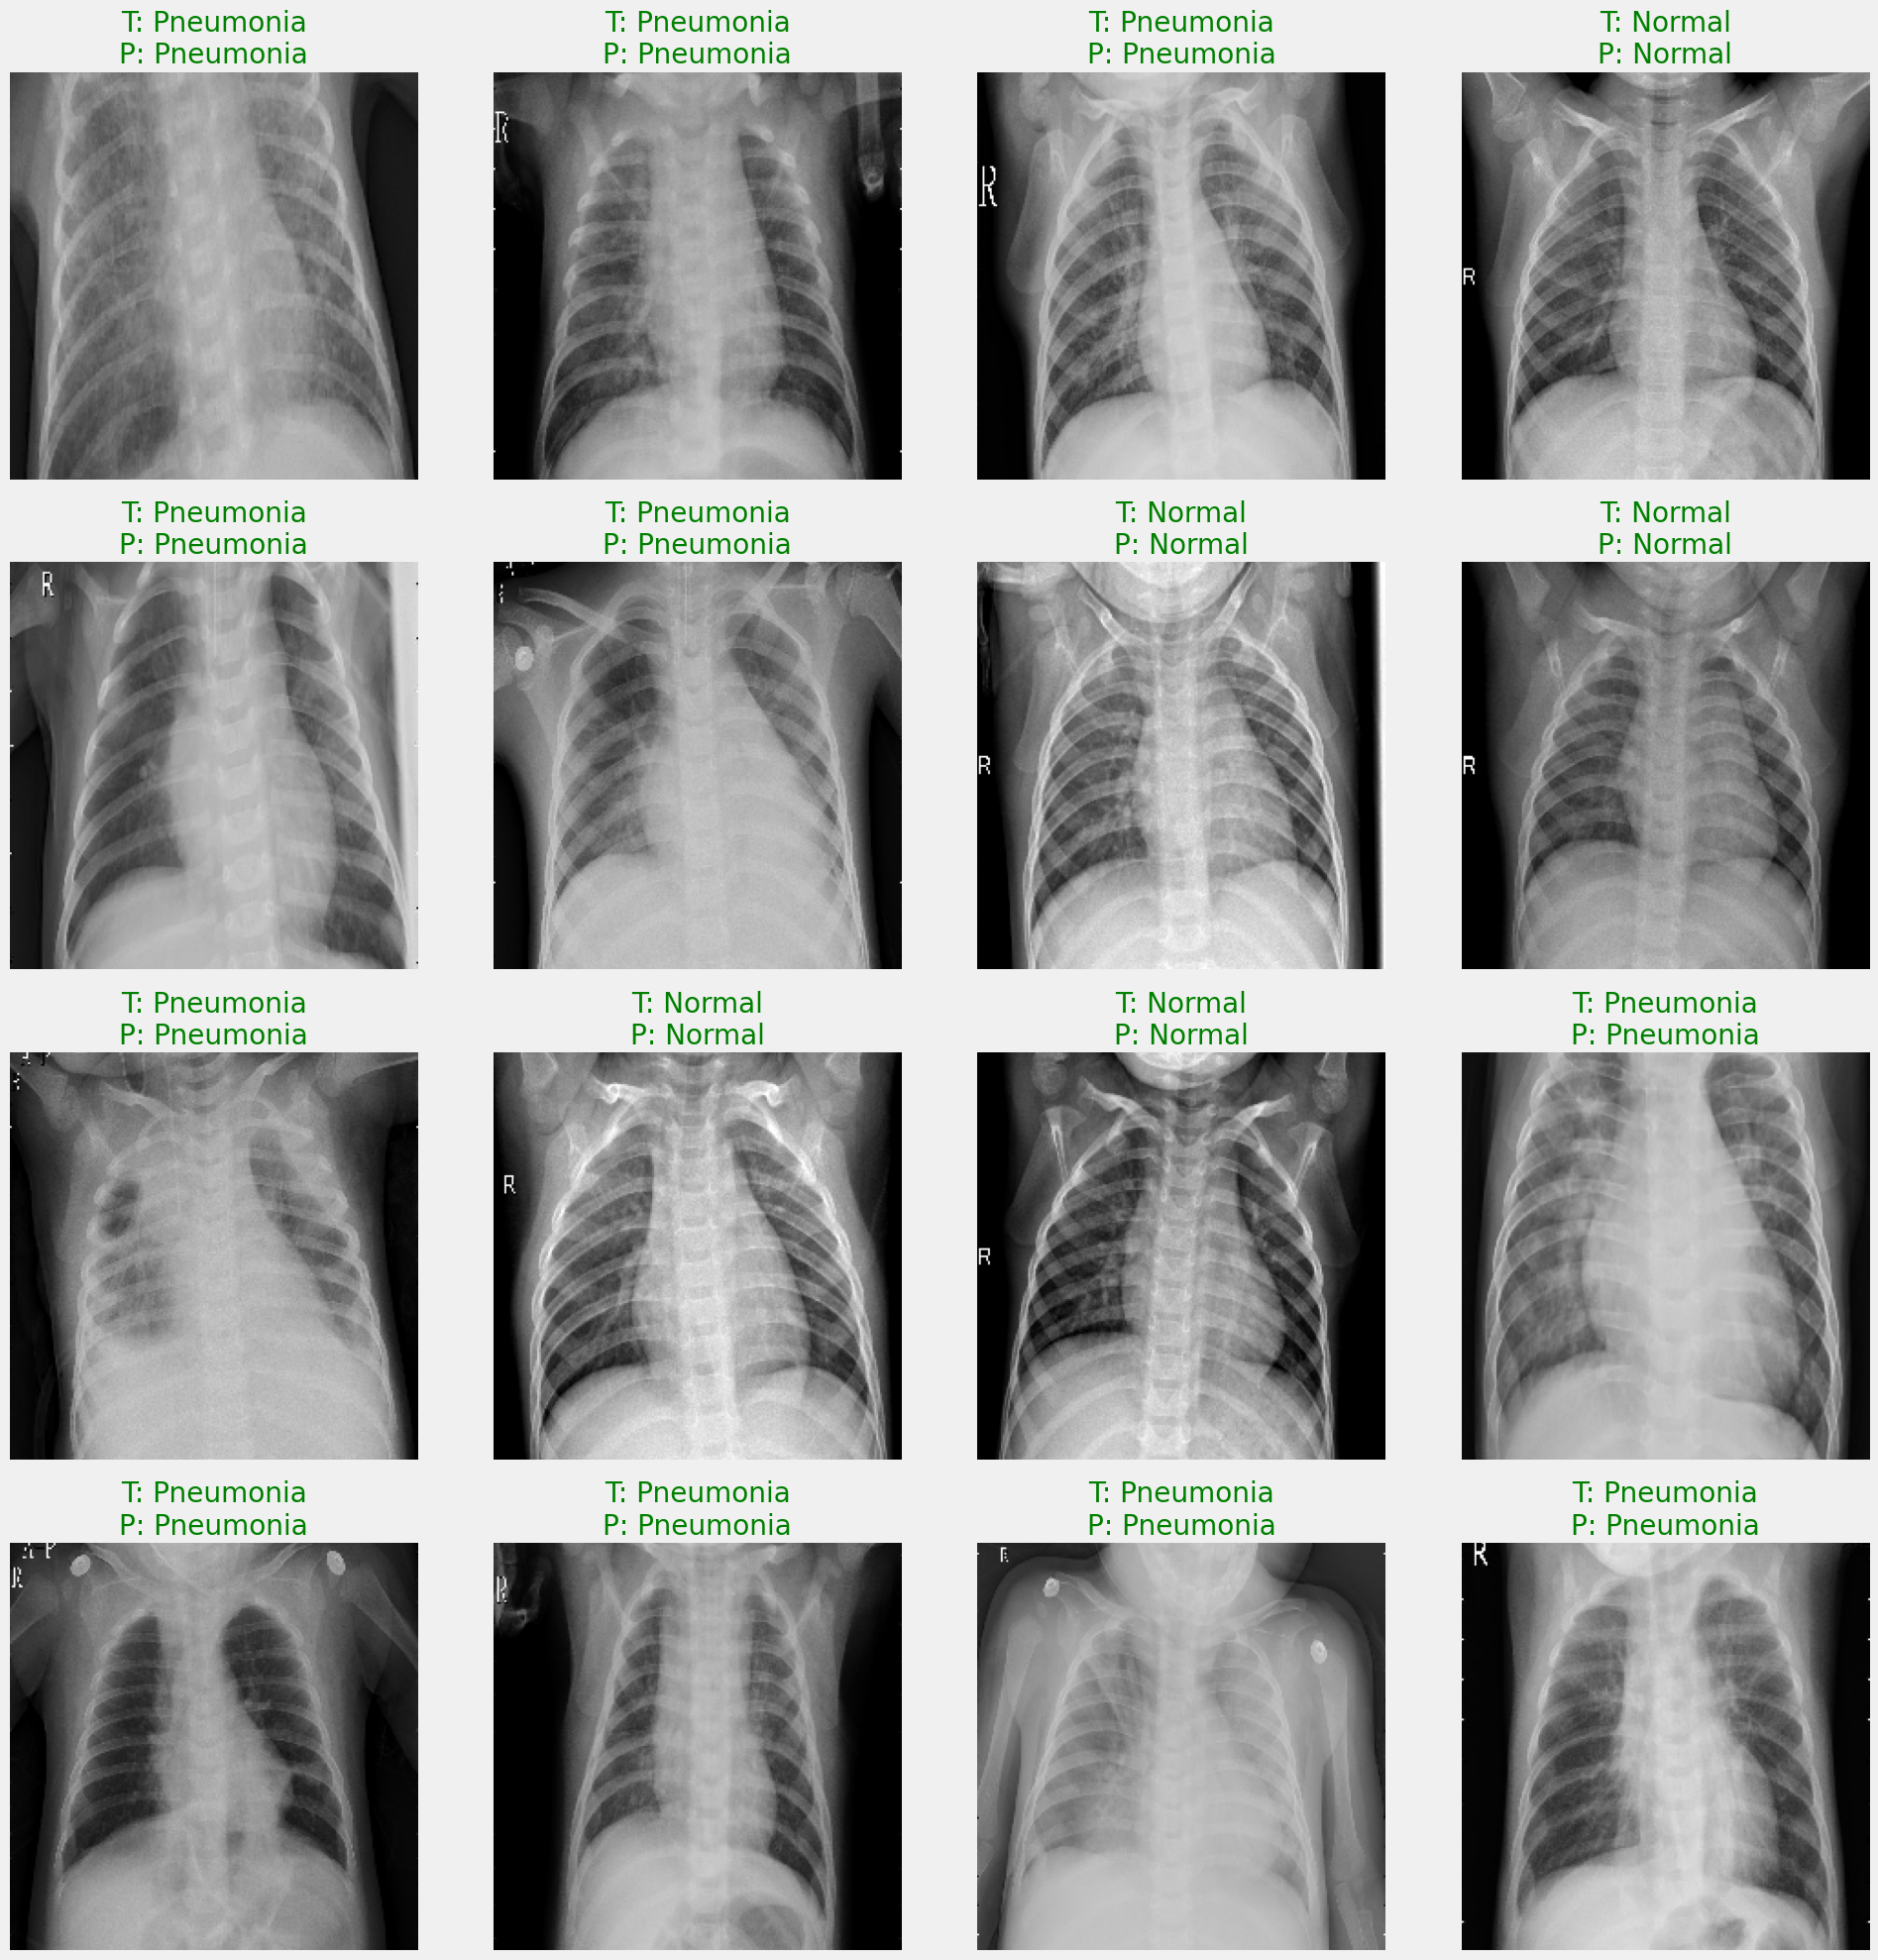

In [26]:
import numpy as np
import matplotlib.pyplot as plt

class_names = ["Normal", "Pneumonia"]

x_test, y_true = next(test_gen)
batch_size = x_test.shape[0]
n_images = min(16, batch_size)

x_test = x_test[:n_images]
y_true = y_true[:n_images]

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

plt.figure(figsize=(20, 20))
for i in range(n_images):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x_test[i].astype("uint8"))
    plt.axis("off")
    true_label = class_names[y_true_classes[i]]
    pred_label = class_names[y_pred_classes[i]]
    plt.title(f"T: {true_label}\nP: {pred_label}", color=("green" if true_label == pred_label else "red"))

plt.tight_layout()
plt.show()


### Prediction Time Calculation:

In [27]:
#Summary of Test Batches
print(f"Number of batches:{len(test_gen)}")
print(f"Classes:{test_gen.class_indices}")

Number of batches:33
Classes:{'NORMAL': 0, 'PNEUMONIA': 1}


In [28]:
#Measure Prediction time for the entire test set
import time

start_time = time.time()
predictions = model.predict(test_gen)
end_time = time.time()

#Calculate average prediction time per image
total_images = len(test_gen) * test_gen.batch_size
batch_time = end_time - start_time
average_time_per_image = batch_time / total_images

print(f"Batch Prediction Time: {batch_time:.2f}seconds")
print(f"Average Prediction Time per Image: {average_time_per_image:.4f}seconds")

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step
Batch Prediction Time: 4.88seconds
Average Prediction Time per Image: 0.0092seconds


## 11. Fairness and Biases

### ROC Curve:

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import seaborn as sns


In [30]:
def plot_roc_bias_mitigation(y_true, y_probs):
    """
    Plots the ROC Curve and returns FPR, TPR, and Thresholds for bias mitigation.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_probs[:, 1])  # Assuming binary classification
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Bias Mitigation')
    plt.legend(loc='lower right')
    plt.show()
    
    # Return the FPR, TPR, and thresholds for threshold adjustment
    return fpr, tpr, thresholds


In [31]:
# Assuming test_batches is the test data generator from ImageDataGenerator
# Ensure the test_batches is properly defined before running this cell
y_true = test_gen.classes  # Extract true labels
y_probs = model.predict(test_gen)  # Generate predicted probabilities


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step


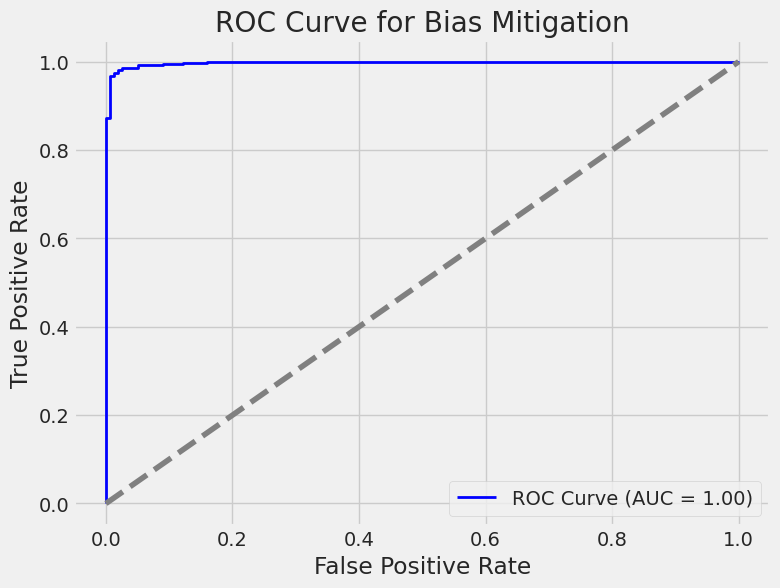

In [32]:
# Plot the ROC Curve and capture thresholds for decision boundary adjustments
fpr, tpr, thresholds = plot_roc_bias_mitigation(y_true, y_probs)


### Side-by-side KDE Plots:

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step


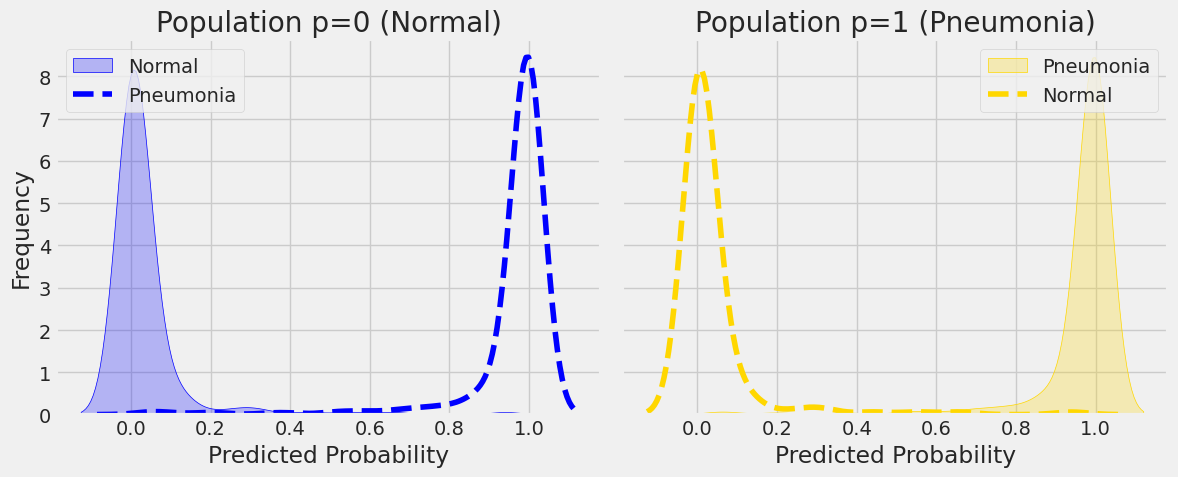

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Assuming test_gen is your test data generator and preds are model predictions
# Extract true labels and predicted probabilities for visualization
y_true = test_gen.classes  # True labels
preds = model.predict(test_gen)
y_probs = preds[:, 1]  # Predicted probability for class 1 (Pneumonia)

# Ensure arrays are properly flattened for Pandas DataFrame usage
y_true = np.array(y_true).flatten()
y_probs = np.array(y_probs).flatten()

# Separate scores for normal and pneumonia with proper filtering
normal_scores = y_probs[y_true == 0]  # Class 0: Normal
pneumonia_scores = y_probs[y_true == 1]  # Class 1: Pneumonia

# Ensure both arrays are 1D
normal_scores = normal_scores.flatten()
pneumonia_scores = pneumonia_scores.flatten()

# Convert to DataFrame for easier visualization
df = pd.DataFrame({
    'score': np.concatenate([normal_scores, pneumonia_scores]),
    'label': ['Normal'] * len(normal_scores) + ['Pneumonia'] * len(pneumonia_scores)
})

# Create side-by-side KDE Plots for Normal and Pneumonia
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Plot for Normal Group (p=0)
sns.kdeplot(normal_scores, fill=True, color="blue", ax=axs[0], label="Normal")
sns.kdeplot(pneumonia_scores, linestyle="--", color="blue", ax=axs[0], label="Pneumonia")
axs[0].set_title("Population p=0 (Normal)")
axs[0].set_xlabel("Predicted Probability")
axs[0].set_ylabel("Frequency")
axs[0].legend()

# Plot for Pneumonia Group (p=1)
sns.kdeplot(pneumonia_scores, fill=True, color="gold", ax=axs[1], label="Pneumonia")
sns.kdeplot(normal_scores, linestyle="--", color="gold", ax=axs[1], label="Normal")
axs[1].set_title("Population p=1 (Pneumonia)")
axs[1].set_xlabel("Predicted Probability")
axs[1].legend()

plt.tight_layout()
plt.show()


## 12. Save the Model

In [34]:
#save to h5 file

from tensorflow.keras.models import load_model

model.save('Custom_CNN.h5')

## 13. Explainable AI (GradCAM)

In [35]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [36]:
# ✅ Class names for display purposes
CLASS_NAMES = ['Normal', 'Pneumonia']

class GradCAM:
    def __init__(self, model, alpha=0.8, beta=0.3):
        self.model = model
        self.alpha = alpha
        self.beta = beta

    def apply_heatmap(self, heatmap, image):
        """Apply the heatmap to the original image."""
        heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
        heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

        # ✅ Ensure image is converted to NumPy before applying .astype()
        image = image.numpy() if isinstance(image, tf.Tensor) else image
        superimposed_img = cv2.addWeighted(image.astype(np.float32), self.alpha, heatmap.astype(np.float32), self.beta, 0)
        return np.uint8(superimposed_img)

    def gradCAM(self, x_test, name='block5_pool', index_class=0):
        """Generate the Grad-CAM heatmap."""
        with tf.GradientTape() as tape:
            last_conv_layer = self.model.get_layer(name)
            grad_model = tf.keras.models.Model(inputs=self.model.input, outputs=[self.model.output, last_conv_layer.output])

            predictions, last_conv_layer_output = grad_model(x_test)
            tape.watch(last_conv_layer_output)
            class_output = predictions[:, index_class]

        grads = tape.gradient(class_output, last_conv_layer_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = tf.reduce_sum(pooled_grads * last_conv_layer_output, axis=-1)

        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)
        return heatmap



### General Predictions Heatmap:

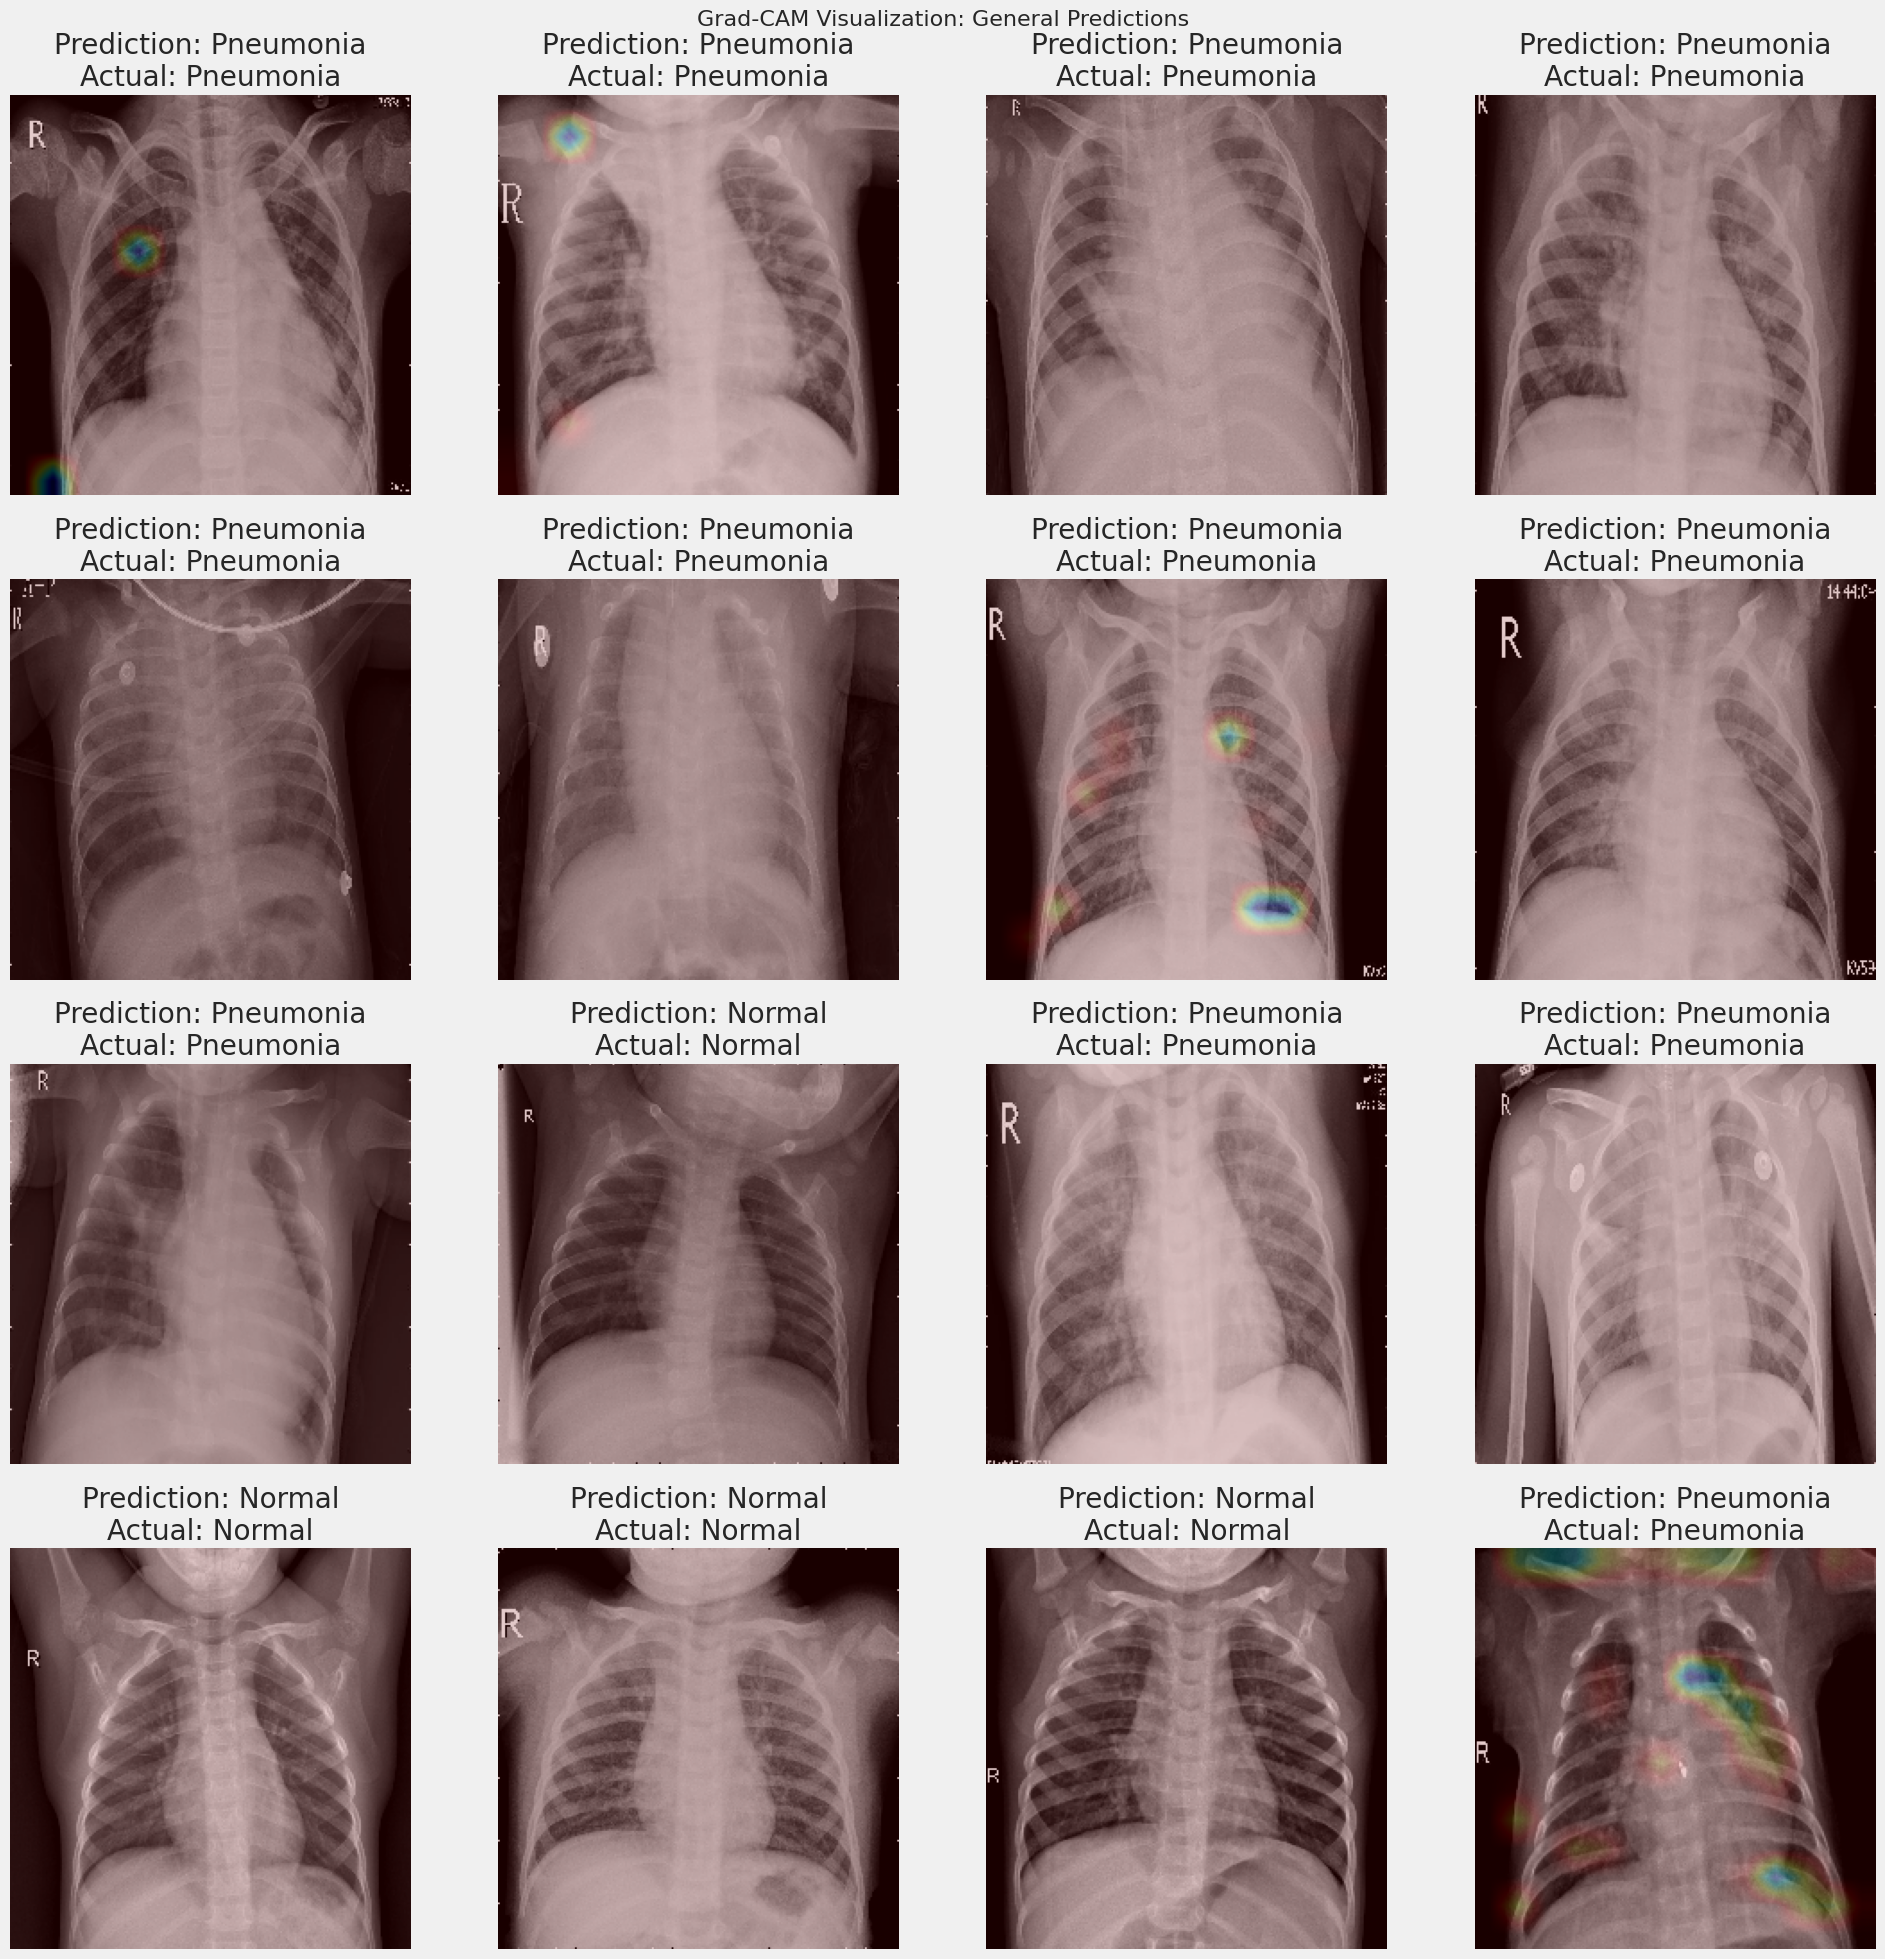

In [37]:
# ✅ Initialize GradCAM
gradCam = GradCAM(model, alpha=0.8, beta=0.2)

# ✅ Generate Grad-CAM heatmaps for general predictions
row, col = 4, 4
fig, axes = plt.subplots(row, col, figsize=(20, 20))
fig.suptitle("Grad-CAM Visualization: General Predictions", fontsize=16)

for index, (x_test, y_test) in enumerate(test_gen):
    x_test_resized = tf.image.resize(x_test[0], (224, 224))
    x_test_expanded = np.expand_dims(x_test_resized, axis=0)
    y_pred = model.predict(x_test_expanded, verbose=0).argmax()
    y_pred_label = CLASS_NAMES[y_pred]
    y_true_label = CLASS_NAMES[np.argmax(y_test[0])]
    
    # ✅ Generate Grad-CAM heatmap
    grad_heatmap = gradCam.gradCAM(x_test_expanded, name='block5_pool', index_class=y_pred)
    
    # ✅ Display Grad-CAM heatmap and the original image with class names
    axes[index // col, index % col].imshow(gradCam.apply_heatmap(grad_heatmap, x_test_resized))
    axes[index // col, index % col].set_title(f"Prediction: {y_pred_label}\nActual: {y_true_label}")
    axes[index // col, index % col].axis('off')

    if index == (row * col) - 1:
        break

plt.tight_layout()
plt.show()


### Incorrect Predictions Heatmap:

In [39]:
# ✅ Collect a smaller batch for efficiency
incorrect_samples = []
max_samples = 200  # Limit the number of test images checked for speed
batch_count = 0

for x_test, y_test in test_gen:
    batch_count += 1
    if batch_count > max_samples:
        break  # Stop checking after max_samples

    x_test_resized = tf.image.resize(x_test[0], (224, 224))
    x_test_expanded = np.expand_dims(x_test_resized, axis=0)
    y_pred = model.predict(x_test_expanded, verbose=0).argmax()
    if y_pred != np.argmax(y_test[0]):
        incorrect_samples.append((x_test_resized, y_pred, np.argmax(y_test[0])))
        if len(incorrect_samples) == 4:
            break

# ✅ Display Grad-CAM heatmaps only for the incorrect predictions (if any exist)
if len(incorrect_samples) > 0:
    fig, axes = plt.subplots(1, len(incorrect_samples), figsize=(20, 6))
    fig.suptitle("Grad-CAM for Incorrect Predictions", fontsize=16)

    for idx, (x_wrong, y_pred, y_true) in enumerate(incorrect_samples):
        # Generate Grad-CAM heatmap for each incorrect sample
        grad_heatmap = gradCam.gradCAM(np.expand_dims(x_wrong, axis=0), name='block5_pool', index_class=y_pred)
        axes[idx].imshow(gradCam.apply_heatmap(grad_heatmap, x_wrong))
        axes[idx].set_title(f"Prediction: {CLASS_NAMES[y_pred]}\nActual: {CLASS_NAMES[y_true]}")
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

    # ✅ Explanation for the Incorrect Prediction Plots
    print("""
    📝 Explanation:
    - The Grad-CAM heatmaps above highlight the regions the model focused on during its incorrect predictions.
    - Warmer areas (red, yellow) represent regions where the model placed more focus while making its decision.
    - Misclassified cases might indicate:
       - Lack of sufficient features in the regions the model focused on.
       - Possible dataset imbalance or noisy images affecting decision-making.
    """)
else:
    print("✅ No incorrect predictions were found in the current test batch!")


✅ No incorrect predictions were found in the current test batch!
